## Задание 6

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    accuracy_score,
    f1_score, 
    precision_score, 
    recall_score
)
from sklearn.utils import shuffle

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from tpot import TPOTClassifier

from fedot.api.main import Fedot

import mlflow
from mlflow.models import infer_signature

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


### Формируем тренировачный датасет

In [2]:
n = 100_000
s = 10_000
skip = sorted(random.sample(range(n), n - s))

In [3]:
df_mitbih_train = pd.read_csv('data/task6_train.csv', header=None, skiprows=skip)
df_mitbih_test = pd.read_csv('data/task6_test.csv', header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [4]:
# Датасет размечен на 5 классов, в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [5]:
id_to_label = {
    0: 'Normal',     # Нормальный
    1: 'Artial Premature', # Преждевременное сокращение сердца (экстрасистолия)
    2: 'Premature ventricular contraction', # Преждевременное сокращение желудочков
    3: 'Fusion of ventricular and normal',  # Cлияние желудочкового и нормального сердечного ритма
    4: 'Fusion of paced and normal' # Cлияние стимулированного и нормального ритма
}

df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)

print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10934 entries, 0 to 2160
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 15.8+ MB
None


In [6]:
df_mitbih_train['class'].value_counts()

class
0.0    7208
4.0     648
2.0     621
1.0     231
3.0      65
Name: count, dtype: int64

In [7]:
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

In [8]:
rus_method = RandomUnderSampler()

df = df_mitbih_train
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df = pd.concat([X_resampled, y_resampled], axis=1)
new_df = new_df.dropna()

df = df_mitbih_test
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df_test = pd.concat([X_resampled, y_resampled], axis=1)
new_df_test = new_df.dropna()

new_df['class'].value_counts()

class
0.0    65
1.0    65
2.0    65
3.0    65
4.0    65
Name: count, dtype: int64

2025-04-22 05:18:10,772 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-22 05:18:10,781 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


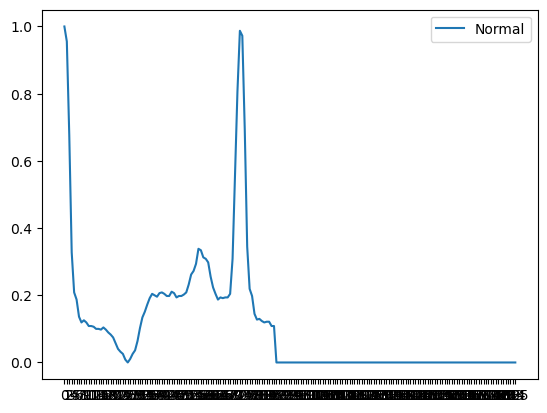

In [9]:
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

### Строим нейронную сеть с эффектом памяти и механизмом внимания

In [10]:
class ECGDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-3].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        
        return signal, target

    def __len__(self):
        return len(self.df)

In [11]:
def get_dataloader(df, phase: str, batch_size: int = 96):
    train_df, val_df = train_test_split(df, test_size=0.15, random_state=123, stratify=df['label'])
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    df = train_df if phase == 'train' else val_df
    
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    
    return dataloader

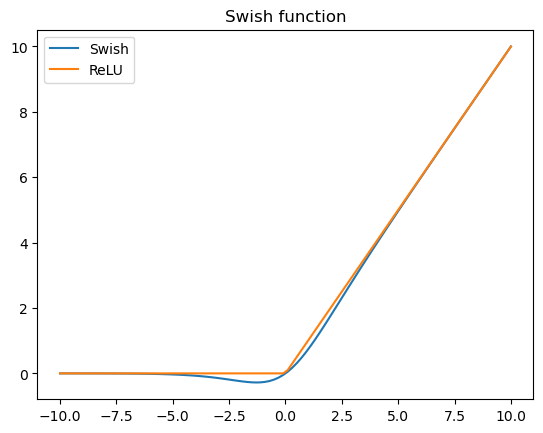

In [12]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

In [13]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p=0.2,
        bidirectional=False,
    ):
        super().__init__()
        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hid_size,
            num_layers=num_rnn_layers,
            dropout=dropout_p if num_rnn_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )
    
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [14]:
class ConvNormPool(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [15]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [16]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion
     

In [17]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
        
    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        print(
            '{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'.format(*(x for kv in metrics.items() for x in kv))
        )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss
    
    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(net.state_dict(), f"./models/task6_best_model_epoc{epoch}.pth")

In [18]:
model = RNNAttentionModel(1, 64, bidirectional=False)

train mode | time: 05:18:18


[W422 05:18:56.191112340 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


loss: 1.628008491342718, accuracy: 0.23999999999999994, f1: 0.17120634920634917, precision: 0.385050505050505, recall: 0.501111111111111


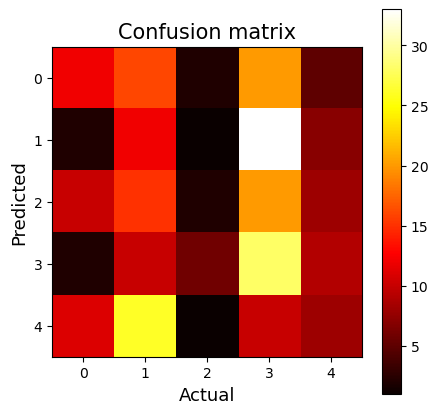

val mode | time: 05:18:58
loss: 1.8298178381390042, accuracy: 0.15555555555555556, f1: 0.11851851851851852, precision: 0.3432098765432098, recall: 0.5310185185185186


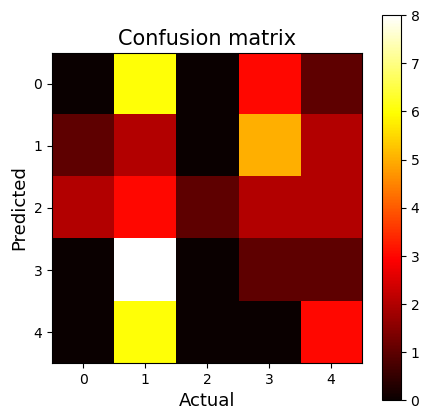


New checkpoint

train mode | time: 05:19:01
loss: 1.6464791883121837, accuracy: 0.23272727272727264, f1: 0.1754386724386724, precision: 0.386060606060606, recall: 0.5146464646464646


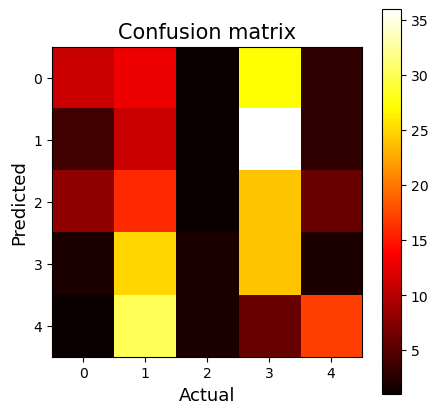

val mode | time: 05:19:40
loss: 1.8052882221009996, accuracy: 0.17777777777777776, f1: 0.1391358024691358, precision: 0.34660493827160493, recall: 0.5212962962962963


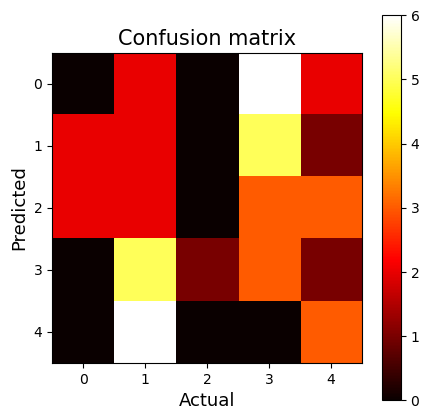


New checkpoint

train mode | time: 05:19:43
loss: 1.6269332452253862, accuracy: 0.25090909090909086, f1: 0.18409090909090906, precision: 0.3943434343434343, recall: 0.4826464646464645


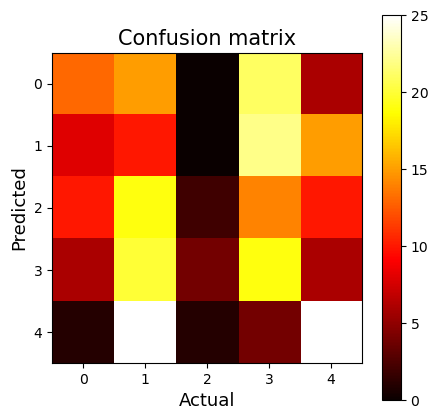

val mode | time: 05:20:22
loss: 1.7610329919391208, accuracy: 0.3111111111111111, f1: 0.2632098765432099, precision: 0.49506172839506185, recall: 0.5080246913580246


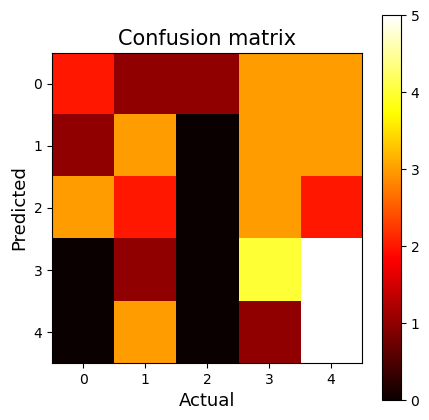


New checkpoint

train mode | time: 05:20:25
loss: 1.6140151132236829, accuracy: 0.23999999999999994, f1: 0.17942424242424238, precision: 0.39722222222222214, recall: 0.45595959595959573


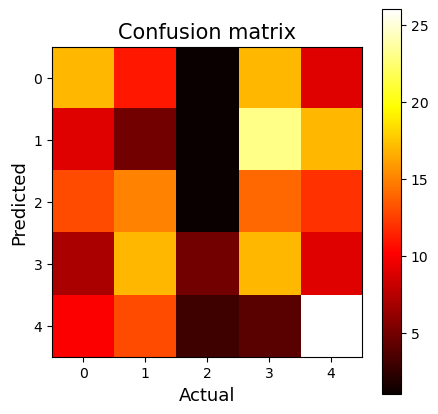

val mode | time: 05:21:04
loss: 1.748454491297404, accuracy: 0.2944444444444445, f1: 0.22592592592592592, precision: 0.4981481481481482, recall: 0.5314814814814814


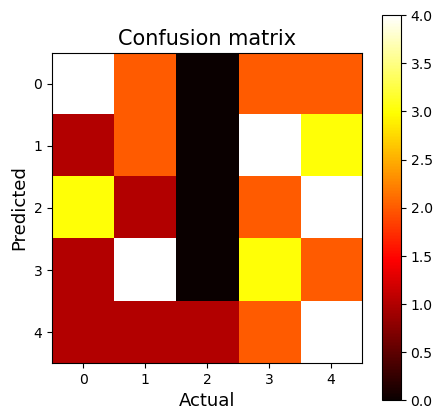


New checkpoint



In [19]:
trainer = Trainer(df=new_df, net=model, lr=1e-3, batch_size=5, num_epochs=4)
trainer.run(net=model)

In [20]:
train_logs = []
val_logs = []

train_logs = trainer.train_df_logs
train_logs.columns = ['train_' + colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ['val_' + colname for colname in val_logs.columns]

logs = pd.concat([train_logs, val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.628008,1.829818,0.240000,0.155556,0.171206,0.118519,0.385051,0.343210,0.501111,0.531019
1,1.646479,1.805288,0.232727,0.177778,0.175439,0.139136,0.386061,0.346605,0.514646,0.521296
2,1.626933,1.761033,0.250909,0.311111,0.184091,0.263210,0.394343,0.495062,0.482646,0.508025
3,1.614015,1.748454,0.240000,0.294444,0.179424,0.225926,0.397222,0.498148,0.455960,0.531481


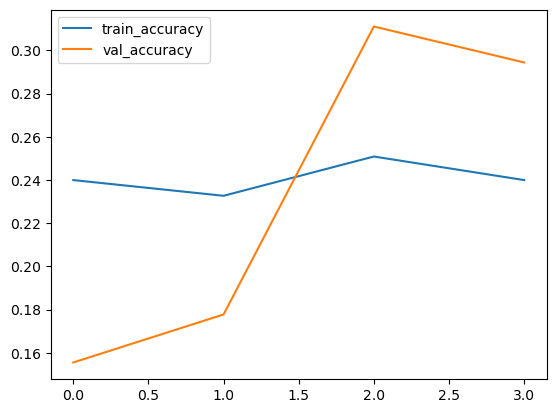

In [21]:
plt.plot(logs['train_accuracy'], label='train_accuracy')
plt.plot(logs['val_accuracy'], label='val_accuracy' )
plt.legend()
plt.show()

In [22]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    
    return predictions_cls, ground_truths_cls

In [23]:
test_dataset = ECGDataset(df_mitbih_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

In [24]:
df_mitbih_test['label'].value_counts()

label
Normal                               1826
Premature ventricular contraction     147
Fusion of paced and normal            134
Artial Premature                       41
Fusion of ventricular and normal       13
Name: count, dtype: int64

In [25]:
y_pred, y_true = make_test_stage(test_dataloader, model)
y_pred.shape, y_true.shape

((2161,), (2161,))

In [26]:
def print_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots() 

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        xticklabels=df['label'].unique(),
        yticklabels=df['label'].unique(),
        cmap='Oranges'
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<Figure size 800x600 with 0 Axes>

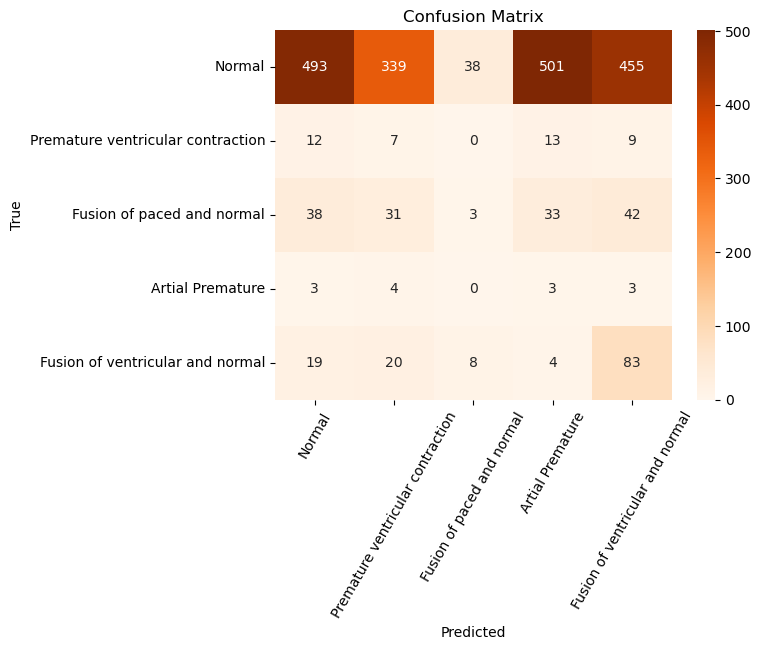

In [27]:
print_cm(y_true, y_pred)

In [28]:
print(multilabel_confusion_matrix(y_true, y_pred))

[[[ 263   72]
  [1333  493]]

 [[1726  394]
  [  34    7]]

 [[1968   46]
  [ 144    3]]

 [[1597  551]
  [  10    3]]

 [[1518  509]
  [  51   83]]]


In [29]:
print(f'Accuracy для тестовых данных: {accuracy_score(y_true, y_pred)}')

Accuracy для тестовых данных: 0.2725590004627487


### Применяем AutoML решения

In [30]:
new_df['class'].value_counts()

class
0.0    65
1.0    65
2.0    65
3.0    65
4.0    65
Name: count, dtype: int64

In [31]:
dfs = []
for i in range(5):
    dfs.append(new_df[new_df['class'] == i].tail(200))

new_short_df = pd.concat(dfs, axis=0)
new_short_df['class'].value_counts()

class
0.0    65
1.0    65
2.0    65
3.0    65
4.0    65
Name: count, dtype: int64

In [32]:
new_df_train = new_df.drop('label', axis=1)
automl = TabularAutoML(
    task=Task('multiclass'),
    timeout=300,
    reader_params={'cv': 3, 'random_state': 0},
    general_params={
        'use_algos': [['lgb', 'cb']],
        'default_algos': ['lgb', 'cb']
    },
    memory_limit=2,
    cpu_limit=1
)

predictions = automl.fit_predict(new_df_train, roles={'target': 'class'}, verbose=1).data

[05:22:46] Stdout logging level is INFO.
[05:22:46] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[05:22:46] Task: multiclass

[05:22:46] Start automl preset with listed constraints:
[05:22:46] - time: 300.00 seconds
[05:22:46] - CPU: 1 cores
[05:22:46] - memory: 2 GB

[05:22:46] Train data shape: (325, 188)

[05:22:50] Layer 1 train process start. Time left 296.34 secs
[05:23:01] Selector_LightGBM fitting and predicting completed
[05:23:01] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[05:23:37] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.6796403174811565
[05:23:37] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[05:23:38] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[05:26:00] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.5952216696503864
[05:26:00] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[05:26:00] Time left 105.63 secs

[05:26:00] Layer 1 training completed.

[05:26:00]

In [33]:
new_df_test = new_df_test.dropna()
new_df_test = new_df_test.drop('label', axis=1)

test_predictions = automl.predict(new_df_test).data

In [34]:
predictions_classes = np.argmax(predictions, axis=1)
test_predictions_classes = np.argmax(test_predictions, axis=1)
train_classes = new_df_train['class']
test_classes = new_df_train['class']

In [35]:
(
    f'Accuracy train data: {accuracy_score(train_classes, predictions_classes)}',
    f'Accuracy test data: {accuracy_score(test_classes, test_predictions_classes)}'
)

('Accuracy train data: 0.7630769230769231', 'Accuracy test data: 1.0')

In [36]:
print(multilabel_confusion_matrix(test_classes, test_predictions_classes))

[[[260   0]
  [  0  65]]

 [[260   0]
  [  0  65]]

 [[260   0]
  [  0  65]]

 [[260   0]
  [  0  65]]

 [[260   0]
  [  0  65]]]


<Figure size 800x600 with 0 Axes>

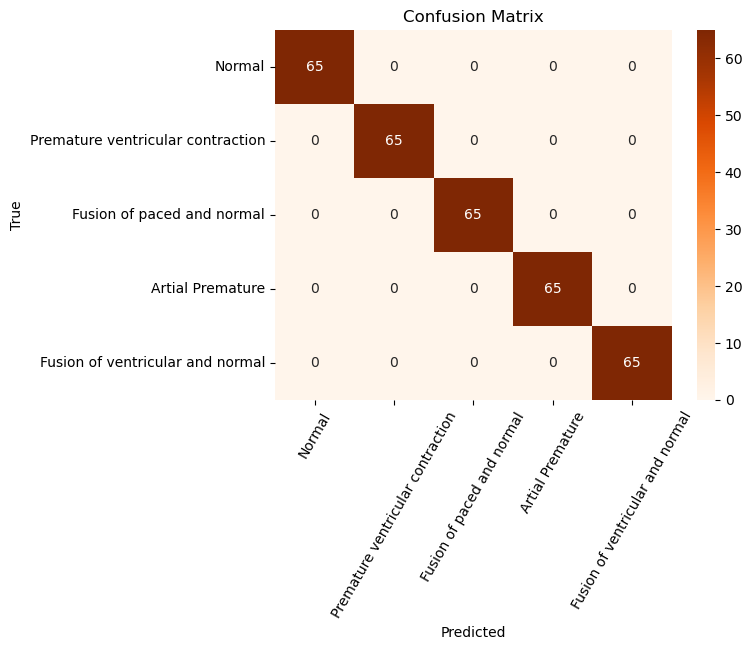

In [37]:
print_cm(test_classes, test_predictions_classes)

In [38]:
X_train = new_df_train.iloc[:, new_df_train.columns != 'class'].values
y_train = new_df_train.iloc[:, new_df_train.columns == 'class'].values.reshape(-1)

In [39]:
tpot = TPOTClassifier(generations=1, population_size=1, random_state=42, max_time_mins=5)
tpot.fit(X_train, y_train)

Generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:06<00:00, 66.65s/it]


TPOTClassifier(max_time_mins=5, random_state=42,
               search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x2aac70084cd0>)

In [40]:
X_test = new_df_test.iloc[:, new_df_test.columns != 'class'].values
y_test = new_df_test.iloc[:, new_df_test.columns == 'class'].values.reshape(-1)

In [41]:
y_train__predict = tpot.predict(X_train)
y_test__predict = tpot.predict(X_test)

In [42]:
(
    f'Accuracy train data: {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data: {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data: 0.84', 'Accuracy test data: 0.84')

In [43]:
print(multilabel_confusion_matrix(y_test, y_test__predict))

[[[249  11]
  [ 10  55]]

 [[250  10]
  [ 14  51]]

 [[246  14]
  [ 15  50]]

 [[247  13]
  [  8  57]]

 [[256   4]
  [  5  60]]]


<Figure size 800x600 with 0 Axes>

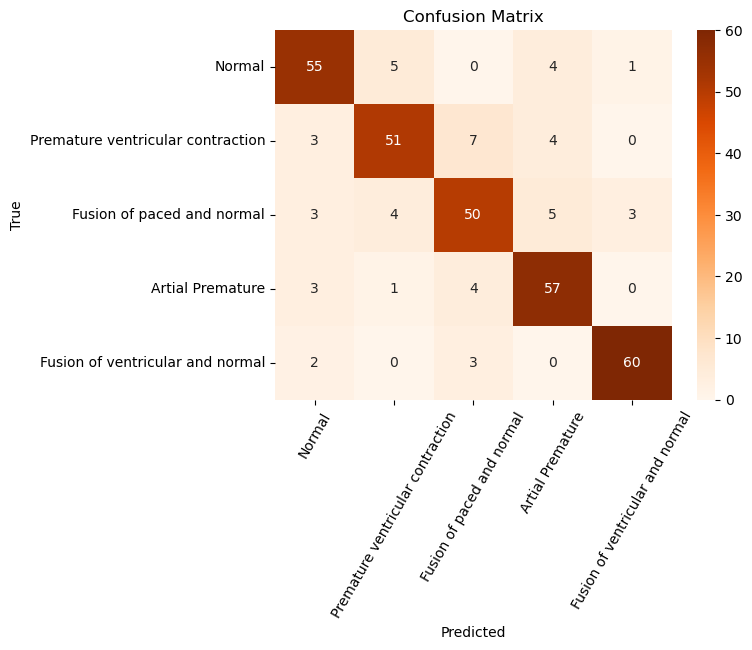

In [44]:
print_cm(y_test, y_test__predict)

In [45]:
fedot_model = Fedot(
    problem='classification',
    n_jobs=-1,
    timeout=3
)
fedot_model.fit(X_train, y_train)

2025-04-22 05:27:30.167955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-04-22 05:28:16,541 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-22 05:28:54,026 - ApiComposer - Initial pipeline was fitted in 33.6 sec.
2025-04-22 05:28:54,044 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 168.0 sec.
2025-04-22 05:28:54,050 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-04-22 05:28:54,117 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].
2025-04-22 05:28:54,782 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 167.951645 sec.
2025-04-22 05:28:54,863 - ApiComposer - Hyperparameters tuning started with 2 min. timeout
2025-04-22 05:32:04,

{'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}

In [46]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [47]:
(
    f'Accuracy train data: {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data: {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data: 0.963076923076923',
 'Accuracy test data: 0.963076923076923')

In [48]:
print(multilabel_confusion_matrix(y_test, y_test__predict))

[[[255   5]
  [  4  61]]

 [[259   1]
  [  1  64]]

 [[257   3]
  [  4  61]]

 [[257   3]
  [  3  62]]

 [[260   0]
  [  0  65]]]


<Figure size 800x600 with 0 Axes>

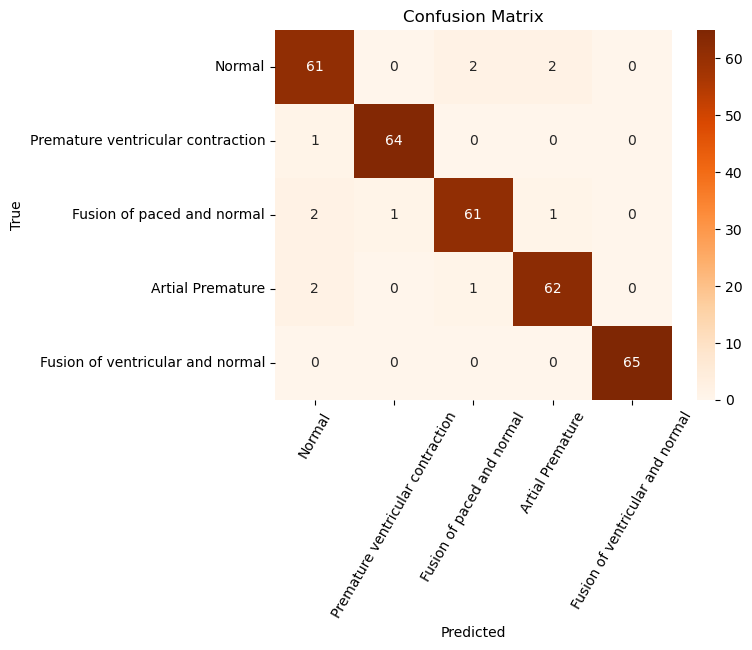

In [49]:
print_cm(y_test, y_test__predict)

### Отображаем результаты в MLFlow

In [50]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')
mlflow.set_experiment('Task6')

2025/04/22 05:35:56 INFO mlflow.tracking.fluent: Experiment with name 'Task6' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/910369438645825044', creation_time=1745300156745, experiment_id='910369438645825044', last_update_time=1745300156745, lifecycle_stage='active', name='Task6', tags={}>

In [52]:
with open('./models/task6_lama.pkl', 'wb') as f:
    pickle.dump(automl, f)

with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'cv': 5, 
            'random_state': 0
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_classes, predictions_classes),
            'Accuracy test data': accuracy_score(test_classes, test_predictions_classes)
        }
    )
    mlflow.log_artifact('./models/task6_lama.pkl')

    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lightautoml_model_task6',
        signature=infer_signature(new_df_train, predictions_classes),
        input_example=new_df_train
    )

🏃 View run LAMA at: http://127.0.0.1:8080/#/experiments/910369438645825044/runs/817bf2ae6aa7472aa18260781ecd9930
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/910369438645825044


In [53]:
with open('./models/task6_tpot.pkl', 'wb') as f:
    pickle.dump(tpot.fitted_pipeline_, f)

with mlflow.start_run(run_name='TPOT'):
    y_train__predict = tpot.predict(X_train)
    y_test__predict = tpot.predict(X_test)

    mlflow.log_params(
        {
            'generations': 1, 
            'population_size': 1, 
            'random_state': 42
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./models/task6_tpot.pkl')

    mlflow.sklearn.log_model(
        sk_model=tpot.fitted_pipeline_,
        artifact_path='tpot_model_task3',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train
    )

🏃 View run TPOT at: http://127.0.0.1:8080/#/experiments/910369438645825044/runs/e154295297b940428800abc53455ba6b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/910369438645825044


In [54]:
with open('./models/task6_fedot.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

with mlflow.start_run(run_name='FEDOT'):
    y_train__predict = fedot_model.predict(X_train)
    y_test__predict = fedot_model.predict(X_test)

    mlflow.log_params(
        {
            'problem': 'classification',
            'n_jobs': -1,
            'timeout': 3
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./models/task6_fedot.pkl')

    model_info = mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='fedot_model_task6',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train
    )

🏃 View run FEDOT at: http://127.0.0.1:8080/#/experiments/910369438645825044/runs/8e7da06847e44f0e95c79ee0425576fb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/910369438645825044
